# Isotropic turbulence with direct energy cascade

In [1]:
import sys, os
sys.path.insert(0, os.path.expanduser("~/Documents/torch-cfd"))


In [2]:
import torch
import torch.fft as fft

from torch_cfd.grids import Grid
from torch_cfd.initial_conditions import filtered_vorticity_field
from torch_cfd.forcings import KolmogorovForcing
from torch_cfd.spectral import *

from fno.data_gen.trajectories import get_trajectory_imex
import xarray
import seaborn as sns
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

/Users/azhir/miniconda3/envs/pc_mri/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n = 256
diam = 2 * torch.pi
dt = 1e-3
T = 10
max_velocity = 7
viscosity = 1e-3
batch_size = 16  # Number of simulations to run in parallel

dt = stable_time_step(
    dx=2 * torch.pi / n, dt=dt, viscosity=viscosity, max_velocity=max_velocity
)
num_snapshots = 100
num_steps = int(T / dt)
record_iters = int(num_steps / num_snapshots)
peak_wavenumber = 6
scale = 1
random_state = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)


grid = Grid(shape=(n, n), domain=((0, diam), (0, diam)), device=device)

vort_init = filtered_vorticity_field(grid, peak_wavenumber, random_state=random_state, batch_size=batch_size)
vort_hat = fft.rfft2(vort_init).data.to(device)

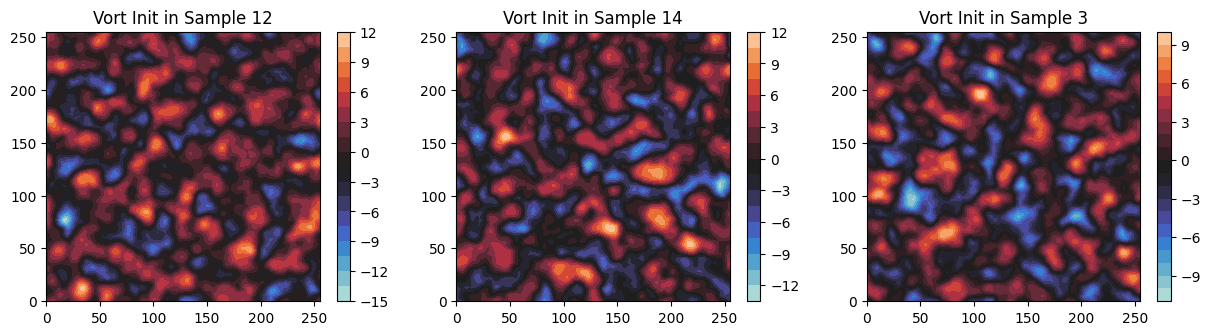

In [4]:
idxes = torch.randperm(batch_size)[:3]
fig, axs = plt.subplots(1, 3, figsize=(15, 3.5))
for i, idx in enumerate(idxes):
    contour = axs[i].contourf(vort_init.data[idx].cpu(), cmap=sns.cm.icefire, levels=20)
    plt.colorbar(contour, ax=axs[i])
    axs[i].set_title(f"Vort Init in Sample {idx}")
plt.show()

In [5]:
ns2d = NavierStokes2DSpectral(
    viscosity=viscosity,
    grid=grid,
    smooth=True,
    step_fn=RK4CrankNicolsonStepper(),
).to(device)

result = get_trajectory_imex(
    ns2d, vort_hat, dt, 
    num_steps=num_steps, 
    record_every_steps=record_iters, pbar=True
)
vort = fft.irfft2(result["vorticity"]).cpu()

velocity = spectral_rot_2d(result["stream"].to(device), grid.rfft_mesh())
velocity = torch.stack(velocity, dim=-3).cpu()
velocity = fft.irfft2(velocity)
vort_t = fft.irfft2(result["vort_t"]).cpu()

29-Aug-2025 18:30:21 - generating trajectories using RK4 - ||L(w) - f||_2: 2.7770e-02 | vort norm 3.1095e+00: 100%|██████████| 10000/10000 [26:23<00:00,  6.32it/s]


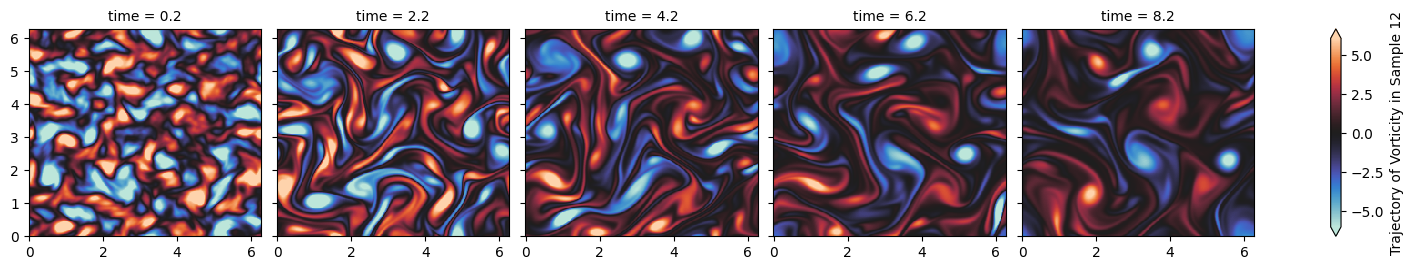

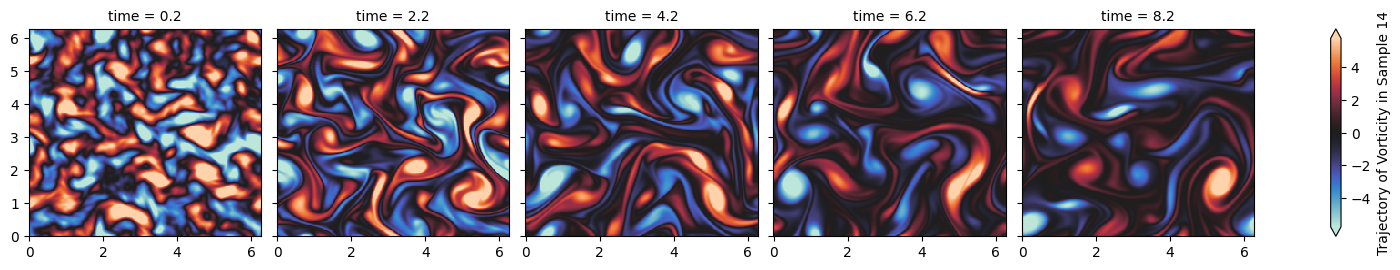

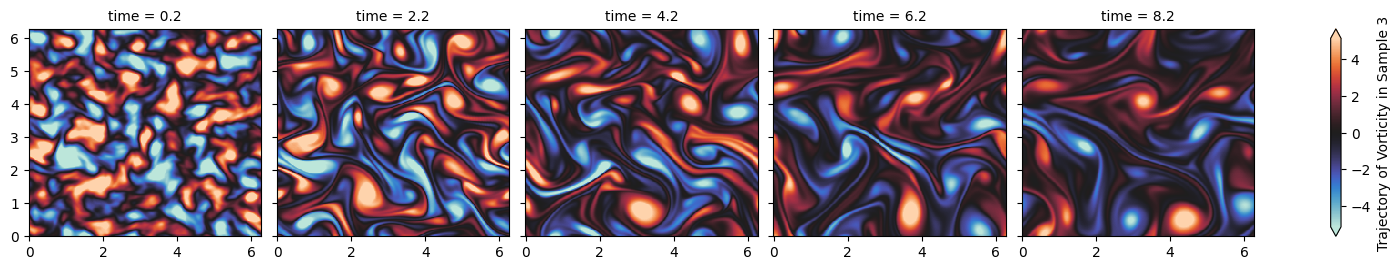

In [6]:
gridx = gridy = torch.arange(n) * 2 * torch.pi / n
coords = {
    "time": record_iters * dt * torch.arange(num_snapshots),
    "x": gridx,
    "y": gridy,
}

for idx in idxes:
    w_data = xarray.DataArray(vort[idx, :num_snapshots], dims=["time", "x", "y"], coords=coords).to_dataset(
        name="vorticity"
    )

    g = w_data["vorticity"].isel(time=slice(2, None)).thin(time=20).plot.imshow(
        col="time", col_wrap=5, cmap=sns.cm.icefire, robust=True,
        xticks=None, yticks=None,
        cbar_kwargs={"label": f'Trajectory of Vorticity in Sample {idx}'}
    )

    g.set_xlabels("")
    g.set_ylabels("")


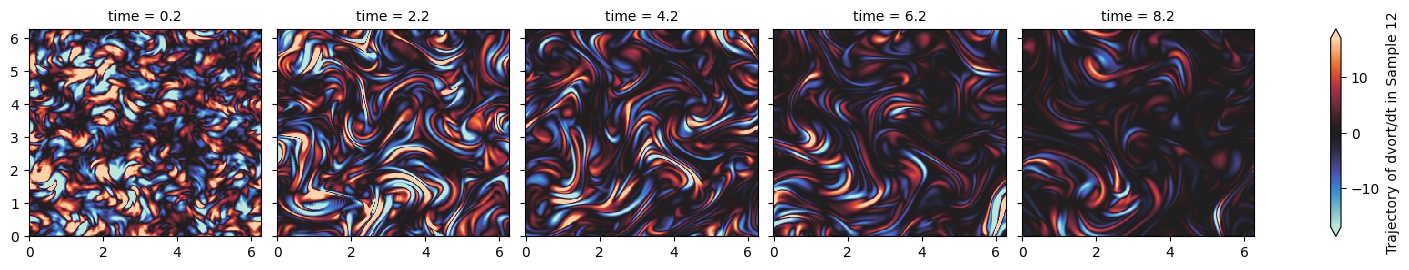

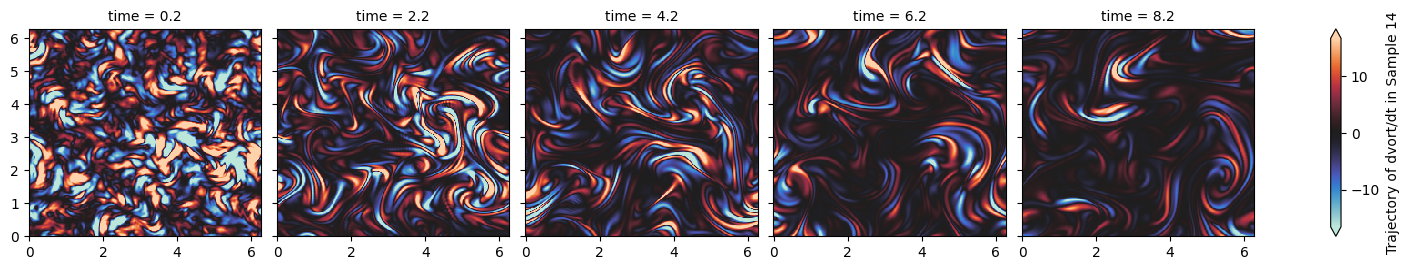

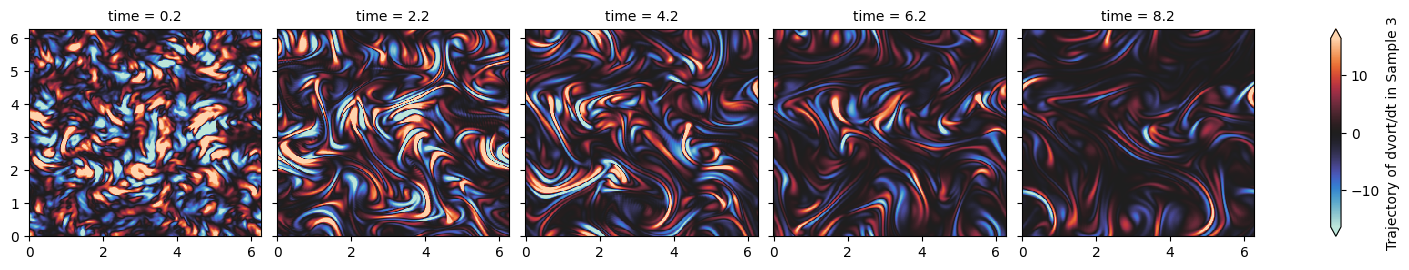

In [7]:
for idx in idxes:
    wt_data = xarray.DataArray(vort_t[idx, :num_snapshots], dims=["time", "x", "y"], coords=coords).to_dataset(
        name="vort_t"
    )
    g = wt_data["vort_t"].isel(time=slice(2, None)).thin(time=20).plot.imshow(
        col="time", col_wrap=5, cmap=sns.cm.icefire, robust=True,
        xticks=None, yticks=None,
        cbar_kwargs={"label": f'Trajectory of dvort/dt in Sample {idx}'}
    )
    g.set_xlabels("")
    g.set_ylabels("")

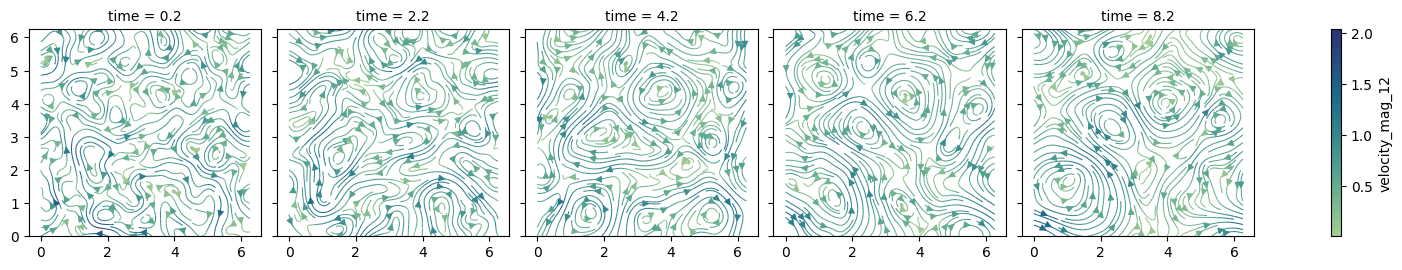

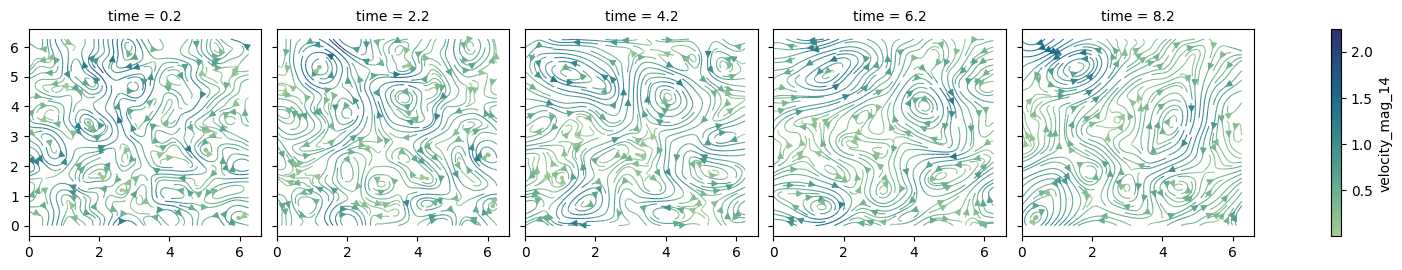

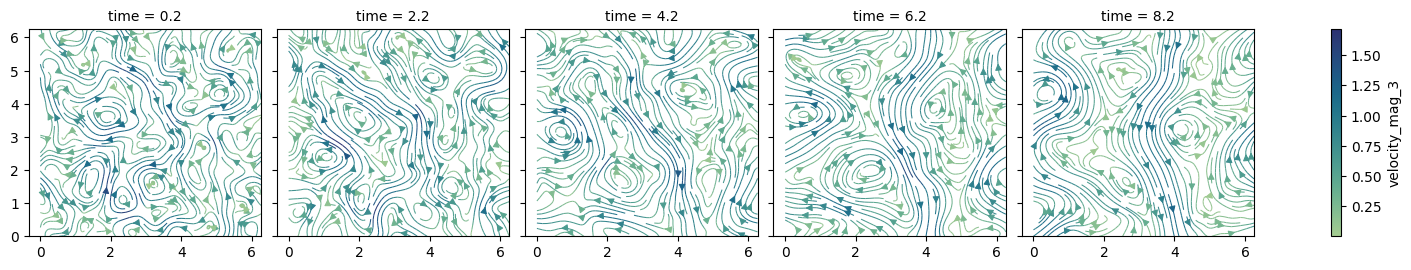

In [9]:
for idx in idxes:
    u_data = xarray.DataArray(
        velocity[idx,:num_snapshots,0], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="u")

    v_data = xarray.DataArray(
        velocity[idx,:num_snapshots,1], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="v")

    velocity_mag = torch.sqrt(velocity[idx,:num_snapshots].pow(2).sum(dim=-3))

    vmag_data = xarray.DataArray(
        velocity_mag, dims=["time", "x", "y"], coords=coords
    ).to_dataset(name=f"velocity_mag_{idx}")

    data = xarray.merge([u_data, v_data, vmag_data])

    g = data.isel(time=slice(2, None)).thin(time=20).plot.streamplot(
        x="x",
        y="y",
        u="u",
        v="v",
        hue=f"velocity_mag_{idx}",
        linewidth=0.75,
        col="time",
        col_wrap=5,
        density=1.6,
        cmap=sns.cm.crest,
        broken_streamlines=True,
    )
    g.set_xlabels("")
    g.set_ylabels("")

[auto] max|u_x|=1.5556 -> venc_x=6.8447
[auto] max|u_y|=1.5330 -> venc_y=6.7451
[u_x] MAE=4.0041e-17, RMSE=6.9095e-17
[u_y] MAE=3.8807e-17, RMSE=6.8001e-17


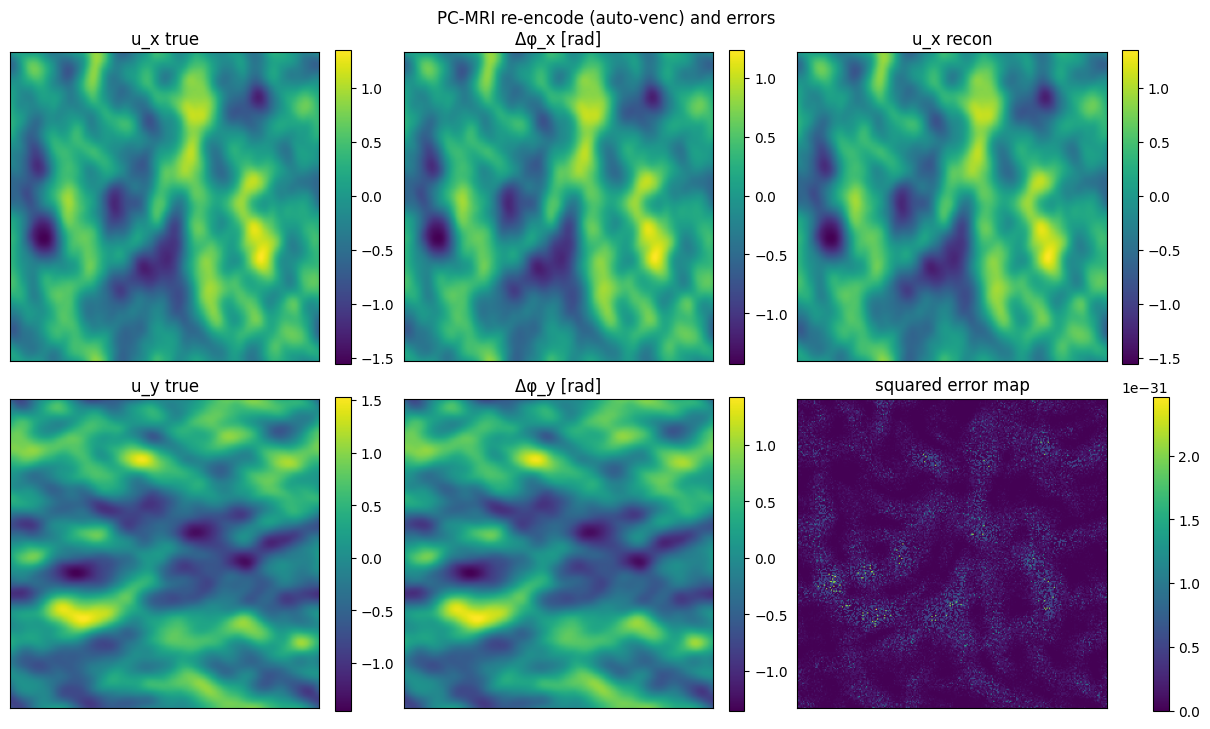

In [13]:
# --- Auto-venc re-encode, metrics, and error map ---

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Grab your velocity dataset (same 'data' produced earlier)
ux = data['u']  # (time,x,y)
uy = data['v']

# 1) Pick a time frame for inspection (use the same one each time)
t_sel = 0

# 2) Compute safe vencs (factor>2 guards against edge cases & numeric noise)
max_abs_ux = float(np.abs(ux.isel(time=t_sel)).max())
max_abs_uy = float(np.abs(uy.isel(time=t_sel)).max())
safety = 2.2  # >2 to be safe; increase if any wrap remains
venc_x = safety * 2.0 * max_abs_ux if max_abs_ux > 0 else 1.0
venc_y = safety * 2.0 * max_abs_uy if max_abs_uy > 0 else 1.0

print(f"[auto] max|u_x|={max_abs_ux:.4f} -> venc_x={venc_x:.4f}")
print(f"[auto] max|u_y|={max_abs_uy:.4f} -> venc_y={venc_y:.4f}")

# 3) Re-encode with those vencs on the selected frame for quick validation
ux2d = ux.isel(time=t_sel).values
uy2d = uy.isel(time=t_sel).values

Sx_pos = np.exp(1j * np.pi * ux2d / venc_x)
Sx_neg = np.exp(-1j * np.pi * ux2d / venc_x)
Sy_pos = np.exp(1j * np.pi * uy2d / venc_y)
Sy_neg = np.exp(-1j * np.pi * uy2d / venc_y)

dphi_x = np.angle(Sx_pos * np.conj(Sx_neg))    # [-pi, pi]
dphi_y = np.angle(Sy_pos * np.conj(Sy_neg))

ux_hat = (dphi_x / (2.0*np.pi)) * venc_x
uy_hat = (dphi_y / (2.0*np.pi)) * venc_y

# 4) Error metrics
mae_x = np.mean(np.abs(ux_hat - ux2d))
rmse_x = np.sqrt(np.mean((ux_hat - ux2d)**2))
mae_y = np.mean(np.abs(uy_hat - uy2d))
rmse_y = np.sqrt(np.mean((uy_hat - uy2d)**2))

print(f"[u_x] MAE={mae_x:.4e}, RMSE={rmse_x:.4e}")
print(f"[u_y] MAE={mae_y:.4e}, RMSE={rmse_y:.4e}")

# 5) Visualize error maps to confirm no aliasing
fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)
im0 = axes[0,0].imshow(ux2d, origin='lower'); axes[0,0].set_title('u_x true'); plt.colorbar(im0, ax=axes[0,0])
im1 = axes[0,1].imshow(dphi_x, origin='lower'); axes[0,1].set_title('Δφ_x [rad]'); plt.colorbar(im1, ax=axes[0,1])
im2 = axes[0,2].imshow(ux_hat, origin='lower'); axes[0,2].set_title('u_x recon'); plt.colorbar(im2, ax=axes[0,2])

im3 = axes[1,0].imshow(uy2d, origin='lower'); axes[1,0].set_title('u_y true'); plt.colorbar(im3, ax=axes[1,0])
im4 = axes[1,1].imshow(dphi_y, origin='lower'); axes[1,1].set_title('Δφ_y [rad]'); plt.colorbar(im4, ax=axes[1,1])
im5 = axes[1,2].imshow((ux_hat-ux2d)**2 + (uy_hat-uy2d)**2, origin='lower')
axes[1,2].set_title('squared error map'); plt.colorbar(im5, ax=axes[1,2])

for ax in axes.ravel():
    ax.set_xticks([]); ax.set_yticks([])
plt.suptitle('PC-MRI re-encode (auto-venc) and errors', y=1.02)
plt.show()


In [ ]:
# # === Minimal PC-MRI encoding from your xarray velocity dataset ===
# # Assumes you already have:
# #   - `data` : xarray.Dataset with variables 'u' and 'v' over dims ['time','x','y']
# #              (from your previous cell inside the loop).
# # Fallback: if `data` is not defined, it will build it from `velocity`, `coords`, `idxes`, `num_snapshots`.

# import numpy as np
# import xarray as xr
# import matplotlib.pyplot as plt

# # --------------------------
# # 0) Get a dataset with u,v
# # --------------------------
# if 'data' not in globals() or not isinstance(data, xr.Dataset) or not {'u','v'}.issubset(set(data.data_vars)):
#     assert all(k in globals() for k in ['velocity','coords','idxes','num_snapshots']), \
#         "Couldn't find `data`. Provide `velocity`, `coords`, `idxes`, `num_snapshots` or re-run the previous cell."
#     _idx = int(idxes[0])  # use first index as fallback
#     u_da = xr.DataArray(velocity[_idx, :num_snapshots, 0].cpu().numpy(),
#                         dims=["time","x","y"], coords=coords, name="u")
#     v_da = xr.DataArray(velocity[_idx, :num_snapshots, 1].cpu().numpy(),
#                         dims=["time","x","y"], coords=coords, name="v")
#     data = xr.merge([u_da.to_dataset(), v_da.to_dataset()])

# # --------------------------
# # 1) PC-MRI parameters
# # --------------------------
# # Use VENC formulation: S± = exp( ± i * π * v / venc )
# # Choose venc >= max|v| to avoid phase wraps (set smaller on purpose to test aliasing).
# venc_x = 1.0  # m/s
# venc_y = 1.0  # m/s

# # Optional: add complex Gaussian noise (std in absolute units; 0.0 = no noise)
# noise_std = 0.0

# # --------------------------
# # 2) Forward synth (per direction)
# # --------------------------
# ux = data['u']                          # (time, x, y)
# vy = data['v']

# Sx_pos = np.exp(1j * np.pi * ux / venc_x)
# Sx_neg = np.exp(-1j * np.pi * ux / venc_x)
# Sy_pos = np.exp(1j * np.pi * vy / venc_y)
# Sy_neg = np.exp(-1j * np.pi * vy / venc_y)

# if noise_std > 0.0:
#     rng = np.random.default_rng()
#     def add_noise(S):
#         n = rng.normal(scale=noise_std, size=S.shape) + 1j * rng.normal(scale=noise_std, size=S.shape)
#         return S + n
#     Sx_pos = xr.apply_ufunc(add_noise, Sx_pos)
#     Sx_neg = xr.apply_ufunc(add_noise, Sx_neg)
#     Sy_pos = xr.apply_ufunc(add_noise, Sy_pos)
#     Sy_neg = xr.apply_ufunc(add_noise, Sy_neg)

# # --------------------------
# # 3) Phase difference & inversion
# # --------------------------
# dphi_x = np.angle(Sx_pos * np.conj(Sx_neg))           # in [-π, π]
# dphi_y = np.angle(Sy_pos * np.conj(Sy_neg))

# vx_hat = (dphi_x / (2.0 * np.pi)) * venc_x
# vy_hat = (dphi_y / (2.0 * np.pi)) * venc_y

# # Pack outputs (complex encodes + phase & recon velocities)
# pcmri = xr.Dataset(
#     data_vars=dict(
#         Sx_pos=(["time","x","y"], Sx_pos.data),
#         Sx_neg=(["time","x","y"], Sx_neg.data),
#         Sy_pos=(["time","x","y"], Sy_pos.data),
#         Sy_neg=(["time","x","y"], Sy_neg.data),
#         dphi_x=(["time","x","y"], dphi_x.data),
#         dphi_y=(["time","x","y"], dphi_y.data),
#         vx_hat=(["time","x","y"], vx_hat.data),
#         vy_hat=(["time","x","y"], vy_hat.data),
#     ),
#     coords=data.coords,
#     attrs=dict(venc_x=float(venc_x), venc_y=float(venc_y), noise_std=float(noise_std))
# )

# # --------------------------
# # 4) Quick visual sanity check
# # --------------------------
# t_sel = int(min(0, pcmri.dims['time']-1))  # pick first time frame
# fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

# im0 = axes[0,0].imshow(data['u'].isel(time=t_sel), origin='lower'); axes[0,0].set_title('u_x true [m/s]'); plt.colorbar(im0, ax=axes[0,0])
# im1 = axes[0,1].imshow(pcmri['dphi_x'].isel(time=t_sel), origin='lower'); axes[0,1].set_title('Δφ_x [rad]'); plt.colorbar(im1, ax=axes[0,1])
# im2 = axes[0,2].imshow(pcmri['vx_hat'].isel(time=t_sel), origin='lower'); axes[0,2].set_title('u_x recon [m/s]'); plt.colorbar(im2, ax=axes[0,2])

# im3 = axes[1,0].imshow(data['v'].isel(time=t_sel), origin='lower'); axes[1,0].set_title('u_y true [m/s]'); plt.colorbar(im3, ax=axes[1,0])
# im4 = axes[1,1].imshow(pcmri['dphi_y'].isel(time=t_sel), origin='lower'); axes[1,1].set_title('Δφ_y [rad]'); plt.colorbar(im4, ax=axes[1,1])
# im5 = axes[1,2].imshow(pcmri['vy_hat'].isel(time=t_sel), origin='lower'); axes[1,2].set_title('u_y recon [m/s]'); plt.colorbar(im5, ax=axes[1,2])

# for ax in axes.ravel():
#     ax.set_xticks([]); ax.set_yticks([])
# plt.suptitle('Synthetic PC-MRI (±venc) encoding and inversion', y=1.02)
# plt.show()

# # --------------------------
# # 5) (Optional) save for training
# # --------------------------
# # pcmri.to_netcdf('pcmri_synth.nc')  # enables reloading via xarray
# # np.savez('pcmri_synth.npz',
# #          Sx_pos=pcmri['Sx_pos'].data, Sx_neg=pcmri['Sx_neg'].data,
# #          Sy_pos=pcmri['Sy_pos'].data, Sy_neg=pcmri['Sy_neg'].data,
# #          dphi_x=pcmri['dphi_x'].data, dphi_y=pcmri['dphi_y'].data,
# #          vx_hat=pcmri['vx_hat'].data, vy_hat=pcmri['vy_hat'].data,
# #          venc_x=float(venc_x), venc_y=float(venc_y), noise_std=float(noise_std))
